# Import Packages and Dataset

In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import model_selection
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import math
import copy

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
# A subscriber data set, “subscribers”. Each record is a past or current subscriber to your service.
df_subscribers = pd.read_csv("subscribers.csv")

# A customer service representative data set “customer_service_reps”. Each record is a
# customer service representative who serves multiple subscribers.
df_cs_reps = pd.read_pickle("customer_service_reps")

# A product usage data set, “engagement”. Each record is a measure of product
# engagement for a given subscriber on a given date (if the subscriber had any
# engagement on that date).
df_engagement = pd.read_pickle("engagement")

# Advertising spend, “channel_spend_graduate”. Total spent per select channels per month.
df_c_spend = pd.read_csv("channel_spend_graduate.csv")

# Statement of Work

####  Consultant will execute at least 2 marketing analyses of the following identified priorities:
#### 1) Customer segmentation to help the marketing team design acquisition strategies supporting the Executive team’s growth objective; 
#### 2) Advertising channel spend efficiency and effectiveness, supporting the advertising team’s budget allocation for the upcoming quarter; and
####  a churn model and develop recommendation(s) on an alternative product pricing structure.


# Data Cleaning

In [82]:
# the variables I will be using for customer segmentation are:
# subid, weekly_consumption_hour, preferred_genre, age, male_TF from df_subscriber
# cust_service_mssgs, num_videos_completed, num_videos_rated, app_opens from df_engagement
# therefore I will be cleaning these variables firstly

In [83]:
# drop abnormal age input that are lesser than 10 or greater than 100
df_subscribers.drop(df_subscribers[(df_subscribers['age'] <= 10) | (df_subscribers['age'] >= 100)].index, 
                    inplace = True)

# drop negative weekly consumption hour input
df_subscribers.drop(df_subscribers[df_subscribers['weekly_consumption_hour'] < 0].index, 
                    inplace = True)

In [84]:
# check if there are abnormal values in variables
# preferred_genre
df_subscribers["preferred_genre"].unique()

array(['comedy', 'regional', 'drama', nan, 'other', 'international'],
      dtype=object)

In [85]:
# check if there are abnormal values in variables
# male_TF
df_subscribers["male_TF"].unique()

array([False, True, nan], dtype=object)

In [86]:
# make engagement subid unique
df_engagement = df_engagement.groupby("subid").agg("mean")
df_engagement = df_engagement.reset_index()

In [87]:
# check if there are abnormal values in variables
# cust_service_mssgs
df_engagement["cust_service_mssgs"].unique()

array([0.75      , 1.        , 0.33333333, ..., 1.05405405, 0.85365854,
       1.7972973 ])

In [64]:
# check if there are abnormal values in variables
# num_videos_completed
df_engagement["num_videos_completed"].unique()

array([1.5       , 3.25      , 0.53333333, ..., 0.76811594, 2.25490196,
       1.29333333])

In [65]:
# check if there are abnormal values in variables
# app_opens
df_engagement["app_opens"].unique()

array([ 1.        ,  1.25      ,  0.93333333, ...,  5.97435897,
       10.07692308, 14.19565217])

# Customer Segmentation

In [66]:
# isolate for attributes that are important to customer segmentation:
# subid, weekly_consumption_hour, preferred_genre, age, male_TF
df_segment = df_subscribers[["subid", "weekly_consumption_hour", "preferred_genre", "age", "male_TF"]]

# merge cust_service_mssgs, num_videos_completed, num_videos_rated, app_opens from engagement.csv
# into the segmentation dataset
engage_working = df_engagement[["subid", "app_opens", "cust_service_mssgs", "num_videos_completed", "num_videos_rated"]]
df_segment = pd.merge(df_segment, engage_working, how="inner", on=["subid"])

# drop all nans that were not dealt with in pre-processing
df_segment.dropna(inplace = True)

# get dummies on the categorical variables
df_segment = pd.get_dummies(df_segment, columns=['preferred_genre', 'male_TF'])

# set subid as index
df_segment = df_segment.set_index('subid')

# drop duplicates
df_segment = df_segment.drop_duplicates()

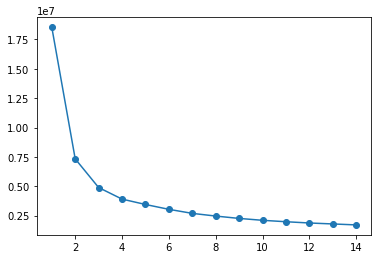

In [67]:
# kmean elbow test to determine optimal cluster number

index = []
inertia = []

for i in range(14):
    model = KMeans(n_clusters=i+1)
    model.fit(df_segment.loc[:,:])
    index.append(i+1)
    inertia.append(model.inertia_)
    
plt.plot(index, inertia, '-o')

In [73]:
# show cluster center
kmeans_4 = KMeans(n_clusters=4).fit(df_segment.loc[:,:].values)

k_4 = kmeans_4.cluster_centers_

pd_k_4 = pd.DataFrame(k_4, columns=df_segment.columns)
pd_k_4 = pd_k_4.round(3)
#pd_k_4.to_csv('pd_k_4.csv')

# Attribution and Allocation

In [74]:
# CAC = total sales and marketing cost/total number of new customer

In [75]:
list(df_c_spend["channel"].unique())

['bing', 'display', 'facebook', 'search', 'youtube']

In [76]:
# isolate for columns of interests
df_allocation = df_subscribers[["subid", "account_creation_date", "attribution_technical", "months_per_bill_period", "discount_price", "join_fee"]]

# modify the account_creation_date column so that it shows only the month
# and rename the column
df_allocation["account_creation_date"] = df_allocation["account_creation_date"].apply(lambda x: x[:8].replace("-",""))
df_allocation.rename(columns={'account_creation_date' : 'account_creation_mo'}, inplace=True)

# drop all nas
df_allocation.dropna(inplace = True)

In [77]:
# isolate for data with channels that have spending data only
bing = df_allocation.loc[df_allocation["attribution_technical"] == "bing"]
display = df_allocation.loc[df_allocation["attribution_technical"] == "display"]
facebook = df_allocation.loc[df_allocation["attribution_technical"] == "facebook"]
search = df_allocation.loc[df_allocation["attribution_technical"] == "search"]
youtube = df_allocation.loc[df_allocation["attribution_technical"] == "youtube"]

df_allocation = bing.append(display).append(facebook).append(search).append(youtube)
df_allocation = df_allocation.reset_index()

In [78]:
# count the number of users acquire through each channel
new_cust = pd.DataFrame(df_allocation.groupby("attribution_technical")["subid"].agg("count"))
new_cust["spending"] = df_c_spend.groupby("channel")["spend_AED"].agg("sum")
new_cust["CAC"] = new_cust["spending"]/new_cust["subid"]

In [80]:
new_cust
#new_cust.to_csv('new_cust.csv')

,subid,spending,CAC
attribution_technical,,,
bing,1132,10800,9.540636
display,1391,366,0.263120
facebook,62775,113500,1.808045
search,22072,222500,10.080645
youtube,906,8730,9.635762


# Churn

In [88]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [90]:
# subset the variables of interest from its respective datasets
# df_subscribers: subid, weekly_consumption_hour, age, male_TF, cancel_date, current_sub_TF
# df_engagement: subid, num_videos_completed, num_videos_rated, num_series_started, 
# and payment_period
temp_sub = df_subscribers[["subid", 
                           "weekly_consumption_hour", "age", "male_TF", "payment_period", 
                           "trial_completed", "current_sub_TF"]]
temp_eng = df_engagement[["subid",
                          "app_opens", "num_videos_completed", "num_videos_rated", "num_series_started"]]

# inner merge the subsets
df_churn = pd.merge(temp_sub, temp_eng, on = "subid")

In [91]:
# to identify whether a customer has churned
# 1) if that user has not finished the trial, or
# 2) if that user is not currently a subscriber

df_churn["churn_TF"] = ((df_churn["trial_completed"] == False) | (df_churn["current_sub_TF"] == False)) * 1
df_churn["male_TF"] = (df_churn["male_TF"] == True) * 1

In [92]:
# drop out the columns used for building churn_TF
df_churn = df_churn.drop(['subid','current_sub_TF', "trial_completed"], axis=1)
df_churn = df_churn.dropna(axis = 'index',how= 'any')
# fill in the nas with mean
#df_churn["age"].fillna(value = df_churn["age"].mean(), inplace = True)
#df_churn["weekly_consumption_hour"].fillna(value = df_churn["weekly_consumption_hour"].mean(), inplace = True)
#df_churn["num_videos_completed"].fillna(value = df_churn["num_videos_completed"].mean(), inplace = True)
#df_churn["num_videos_rated"].fillna(value = df_churn["num_videos_rated"].mean(), inplace = True)
#df_churn["num_series_started"].fillna(value = df_churn["num_series_started"].mean(), inplace = True)
#df_churn["app_opens"].fillna(value = df_churn["app_opens"].mean(), inplace = True)
#df_churn["cust_service_mssgs"].fillna(value = df_churn["cust_service_mssgs"].mean(), inplace = True)

In [93]:
# train, test, split
df_train, df_test = model_selection.train_test_split(df_churn, test_size = 0.3)

In [34]:
df_churn.columns

Index(['weekly_consumption_hour', 'age', 'male_TF', 'payment_period',
       'app_opens', 'num_videos_completed', 'num_videos_rated',
       'num_series_started', 'churn_TF'],
      dtype='object')

In [94]:
# ----- FIT CHURN MODEL ------
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = ['weekly_consumption_hour', 'age', 'male_TF', 'payment_period',
       'app_opens', 'num_videos_completed', 'num_videos_rated',
       'num_series_started'] # list of x covariates
add_constant_TF = True

In [95]:
# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [96]:
# --- fit linear probability model
lpm_model = sm.OLS(endog = df_train[y_col_name], exog = df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                 1.269e+04
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:10:38   Log-Likelihood:                -23517.
No. Observations:               77312   AIC:                         4.705e+04
Df Residuals:                   77303   BIC:                         4.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [97]:
# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())


Optimization terminated successfully.
         Current function value: 0.285521
         Iterations 7

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               churn_TF   No. Observations:                77312
Model:                          Logit   Df Residuals:                    77303
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.5867
Time:                        23:10:43   Log-Likelihood:                -22074.
converged:                       True   LL-Null:                       -53406.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
weekly_consumption_hour    -0.0230      0.003    

In [98]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

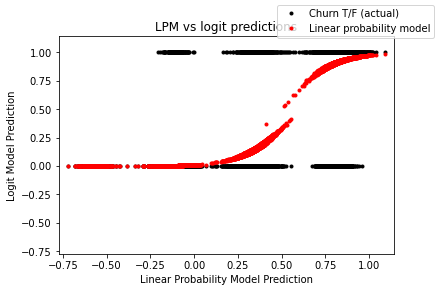

In [99]:
# compare lpm and logit predictions
fig = plt.figure()
ax = plt.gca()
ax.plot(df_test[['prob_churn_lpm']], df_test[['churn_TF']], 'k.')
ax.plot(df_test[['prob_churn_lpm']], df_test[['prob_churn_logit']], 'r.')
plt.ylim(df_test[['prob_churn_lpm', 'prob_churn_logit']].min().min()-.05, df_test[['prob_churn_lpm', 'prob_churn_logit']].max().max()+.05)
plt.xlim(ax.get_ylim())
plt.title('LPM vs logit predictions')
plt.xlabel('Linear Probability Model Prediction')
plt.ylabel('Logit Model Prediction')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])

In [100]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

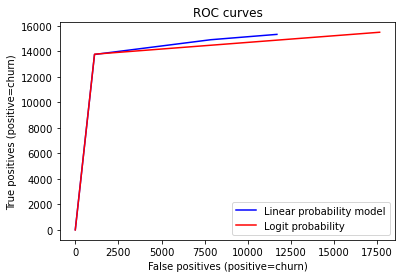

In [101]:
# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])


In [102]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

In [103]:
# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

In [104]:
# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

In [105]:
# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

In [106]:
# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

In [107]:
# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    acceptance_rate_churn = t_discount_amount
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

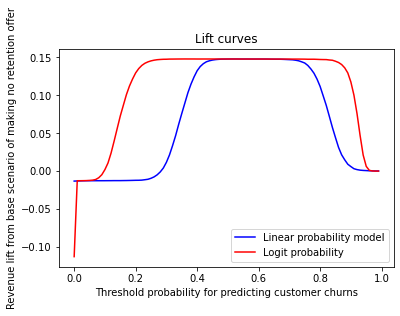

In [108]:
# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])


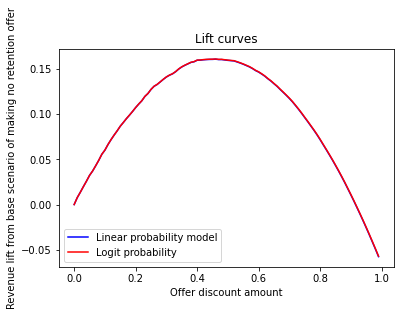

In [50]:
# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])
